In [1]:
%matplotlib TkAgg

import matplotlib.pyplot as plt
import mne
import numpy as np
import scipy
from scipy.signal import butter, sosfilt, freqs
import sys
import lzma
import pandas as pd
import seaborn as sns

In [2]:
def standardizeMatrix(matrixOriginal):
    matrix = np.copy(matrixOriginal)

    floatType = type(matrix[0,0])
    rows, cols = matrix.shape
    matrix = matrix.astype(np.float64)
    
    for i in range(rows):
        mu = np.mean(matrix[i,:])
        sigma = np.std(matrix[i,:])
        matrix[i,:] = (matrix[i,:] - mu) / sigma
    return matrix.astype(floatType)


def elimPeaks(filteredMatrix, sigmaThreshold, sampleHalfWidthElim, sampleMinGap):

    standardizedMatrix = standardizeMatrix(filteredMatrix)
    peakList = []
    nChannel, nSample = standardizedMatrix.shape
    
    for i in range(nChannel):
        for j in range(nSample):
            if np.abs(standardizedMatrix[i,j]) > sigmaThreshold:
                peakList.append(j)
    peakList = list(set(peakList))
    peakList.sort()

    intervalList = [(thisPeak - sampleHalfWidthElim, thisPeak + sampleHalfWidthElim) for thisPeak in peakList]

    mergedIntervalList = [intervalList[0]]
    for i in range(1, len(intervalList)):
        currentInterval = mergedIntervalList[-1]
        nextInterval = intervalList[i]
        if currentInterval[1] + sampleMinGap >= nextInterval[0]:
            mergedIntervalList[-1] = (currentInterval[0], nextInterval[1])
        else:
            mergedIntervalList.append(nextInterval)
        
    startIndex = 0
    matrixList = []
    for i in range(0, len(mergedIntervalList)):
        intervalStart, intervalEnd = mergedIntervalList[i]
        thisMatrix = np.copy(filteredMatrix[:, startIndex:intervalStart])
        matrixList.append(thisMatrix)
        startIndex = intervalEnd + 1

    return matrixList, mergedIntervalList

In [3]:
filename = 'SVD001.edf'
raw = mne.io.read_raw_edf('G:/My Drive/NeuroResearch/Data/eegCompress/ExampleLTMFiles/' + filename)

Extracting EDF parameters from G:\My Drive\NeuroResearch\Data\eegCompress\ExampleLTMFiles\SVD001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jetti\AppData\Local\Temp\ipykernel_12012\626497673.py:2: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf('G:/My Drive/NeuroResearch/Data/eegCompress/ExampleLTMFiles/' + filename)


In [4]:
print(raw)
print(raw.info)

<RawEDF | SVD001.edf, 46 x 1276416 (4986.0 s), ~39 KiB, data not loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F7, T7, P7, O1, F3, C3, P3, A1, Fz, Cz, Fp2, F8, T8, P8, ...
 chs: 46 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2001-01-01 04:46:55 UTC
 nchan: 46
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: SVD001>
>


In [5]:
goodChannels = ['Fp1','F3','C3','P3','O1','Fp2','F4','C4','P4','O2','F7','T7','P7','F8','T8','P8','Fz','Cz','Pz']

In [6]:
sigmaThreshold = 8
sampleHalfWidthElim = 128
sampleMinGap = 256

chanList = mne.pick_channels(raw.info['ch_names'], goodChannels)
dataArray = raw.get_data()[chanList]

#sos = butter(30, [1,lowPass], 'bandpass', fs=256, output='sos')
#dataFiltered = sosfilt(sos, data, -1)

dataList, intervalList = elimPeaks(dataArray, sigmaThreshold, sampleHalfWidthElim, sampleMinGap)

Creating RawArray with float64 data, n_channels=19, n_times=1100367
    Range : 0 ... 1100366 =      0.000 ...  4298.305 secs
Ready.
Using matplotlib as 2D backend.


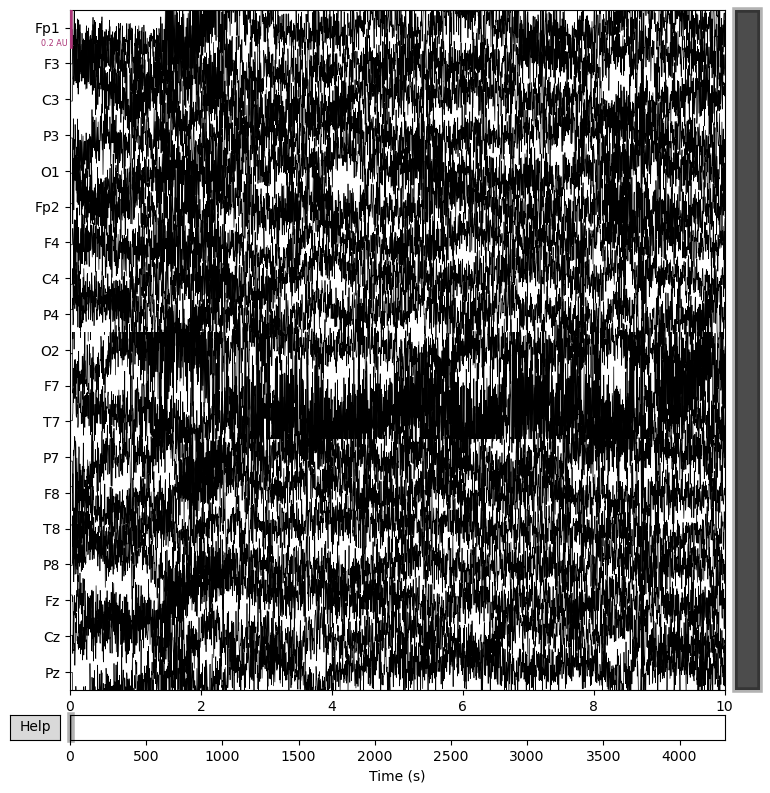

In [15]:
#tempMatrix = tempBlock
#tempMatrix = dataList[7]
#tempMatrix = reconstructBlock

badSampples = np.flip(np.argsort(np.max(np.abs(residual), axis=0)))
thisIndex = 0
tempMatrix = residual

info = mne.create_info(goodChannels, 256)
tempRaw = mne.io.RawArray(tempMatrix, info)
tempRaw.plot()

# Load original and predicted for local graphical comparison

In [3]:
processedData = np.load('G:/My Drive/NeuroResearch/Data/eegCompress/processedData/origAndPredictedSVD001_block7.npz')
#processedData = np.load('G:/My Drive/NeuroResearch/Data/eegCompress/processedData/origAndPredictedLossy.npz')
original = processedData['arr_0']
predicted = processedData['arr_1']
residual = predicted - original
print(np.mean(np.abs(residual)), np.mean(np.abs(original)))

0.06321728580702292 0.67450494


In [85]:
allFlag = 0
channel = 0

plt.figure()
#plt.plot(original[channel,:])

if allFlag:
    for channel in range(0,19):
        plt.plot(residual[channel,:], label = str(channel))
else:
    #plt.plot(predicted[channel,:])
    plt.plot(residual[channel,:])

plt.legend()

C:\Users\jetti\AppData\Local\Temp\ipykernel_12012\1244051460.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


In [19]:
# FIND BAD INTERVALS WHERE RESIDUAL IS LARGE

threshold = .05
badSamples = np.any(residual > threshold, 0)
badSamples

badFlag = False
intervalList = []
for i in range(len(badSamples)):
    if badFlag == False and badSamples[i] == True:
        intervalBegin = i
        badFlag = True
    if badFlag == True and badSamples[i] == False:
        intervalList.append((intervalBegin, i))
        badFlag = False

# Scratch

In [7]:
np.savez_compressed('G:/My Drive/NeuroResearch/Data/eegCompress/processedData/' + 'elimPeaks' + filename[0:-4], *dataList)

In [ ]:
mne.export.export_raw('G:/My Drive/NeuroResearch/Data/eegCompress/processedData/decompressed.edf', tempRaw)

In [ ]:
np.save('G:/My Drive/NeuroResearch/Data/eegCompress/processedData/' + filename[0:-4], data)

In [18]:
np.savetxt('C:/Users/jetti/data/eegCompress/' + 'elimpeaks' + filename[0:-4] + '.csv', dataList[7])

In [ ]:
blockIndex = 7
numChannel = 19

block = dataList[blockIndex]
numBytesInOriginalData = 8

factor = 10**6
newType = np.int8

mySize = 0
reconstructBlock = np.zeros_like(block)
for chanIndex in range(numChannel):
    chan = block[chanIndex,:]

    chanDiff = np.diff(chan) * factor
    chanDiffNewType = np.round(chanDiff).astype(newType)

    myCompress = lzma.compress(chanDiffNewType, preset = 9)
    #myDecompress = lzma.decompress(myCompress)
    #myDecompress = [i if i < 128 else (i - 256) for i in myDecompress]

    first = (chan[0] * factor).astype(newType)
    chanReconstruct = np.insert(np.cumsum(chanDiff) + first, 0, first)
    reconstructBlock[chanIndex,:] = np.copy(chanReconstruct)

    mySize = mySize + sys.getsizeof(myCompress)
    
# calculate compression via bytes
print((len(chan) * numBytesInOriginalData * numChannel)/ mySize)